In [27]:
#!python3 -m pip install matplotlib_venn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from matplotlib_venn import venn2
from matplotlib.ticker import ScalarFormatter

In [28]:
#colors
sns.set_style("whitegrid")
bgi_main = '#5eaab3'
bgi_lght = '#aacfd5'
ill_main = '#ee7339'
shared_cl = '#94a577'
main_cl = '#1c4e9c'

In [29]:
def clean_microbiome_df(df, shared_samples):
    df = df.copy()
    # Filter out sp. with relative abundance < 0.001
    df[df < 0.001] = 0

    # Filter out all unclassified sp.
    df = df[~df.index.astype(str).str.startswith('bin')]

    # Keep only shared samples
    df = df[df.columns.intersection(shared_samples)]

    # Drop rows and columns that contain only zeros
    df = df.loc[~(df == 0).all(axis=1)]  
    df = df.loc[:, ~(df == 0).all(axis=0)]  

    return df

from numpy import mean
from numpy import var
from math import sqrt

def cohend(d1,d2):
    n1, n2 = len(d1), len(d2)
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = mean(d1), mean(d2)
    return (u1 - u2) / s


## Read data

In [30]:
### Read Kraken data.Species level
mgi1_df = pd.read_csv("/Users/katerynapantiukh/Library/CloudStorage/OneDrive-TartuÜlikool/2023_Illumina_vs_BGI/kraken/old/abud_results/Intra-Platform_set/BGI_dup1_merged_output_all.csv", index_col=0)
mgi1_df.columns = mgi1_df.columns.str.replace('bgi_', '')
mgi2_df = pd.read_csv("/Users/katerynapantiukh/Library/CloudStorage/OneDrive-TartuÜlikool/2023_Illumina_vs_BGI/kraken/old/abud_results/Intra-Platform_set/BGI_dup2_merged_output_all.csv", index_col=0)
mgi2_df.columns = mgi2_df.columns.str.replace('bgi_dup2_', '')

# Select only shared samples
shared_samples = list(set(mgi1_df.columns) & set(mgi2_df.columns))
print("Shared samples:", len(shared_samples))
        
mgi1_df = clean_microbiome_df(mgi1_df, shared_samples)
mgi2_df = clean_microbiome_df(mgi2_df, shared_samples)

print("MGI-1 samples:", len(mgi1_df.columns))
print("MGI-2 samples:", len(mgi2_df.columns), '\n')
print("MGI-1 species:", len(mgi1_df.index))
print("MGI-2 species:", len(mgi2_df.index))

mgi1_df.head(2)

Shared samples: 53
MGI-1 samples: 53
MGI-2 samples: 53 

MGI-1 species: 1063
MGI-2 species: 1066


,V09EVV,V5IRLB,VA1SJX,VPIGAR,VVJ28F,V7TBJ3,VKOABJ,VNHZE6,VA6KWA,VQ9DGJ,...,VCRLAE,VCGAL2,VP5JJE,VNUP14,VN1NZJ,VO3TPZ,VYS7CL,VC1TRL,VJUCKK,V86Z0W
name,,,,,,,,,,,,,,,,,,,,,
Phocaeicola plebeius_A,0.06578,0.03279,0.0,0.0,0.00168,0.10514,0.0,0.00405,0.00708,0.00248,...,0.00000,0.0,0.0,0.0,0.00118,0.0,0.01329,0.00000,0.02901,0.00000
Phocaeicola sp000432735,0.04625,0.00289,0.0,0.0,0.00144,0.08958,0.0,0.00000,0.00000,0.00000,...,0.00663,0.0,0.0,0.0,0.00000,0.0,0.01182,0.00324,0.00000,0.01957


In [31]:
all_sp = set(mgi1_df.index) | set(mgi2_df.index)
print("All detected species: ", len(all_sp))
print("Species present in both MGI-1 & MGI-2 set: ", len(set(mgi1_df.index) & set(mgi2_df.index)))
print("Species present only in MGI-1 set: ", len(set(mgi1_df.index) - set(mgi2_df.index)))
print("Species present only in MGI-2 set: ", len(set(mgi2_df.index) - set(mgi1_df.index)), '\n')

unique1 = set(mgi1_df.index) - set(mgi2_df.index)
unique2 = set(mgi2_df.index) - set(mgi1_df.index)
uniqueT = set(unique1) | set(unique2)
print("Proportion of not shared species in MGI-1: ", len(uniqueT)/ len(all_sp) * 100, '\n')


All detected species:  1083
Species present in both MGI-1 & MGI-2 set:  1046
Species present only in MGI-1 set:  17
Species present only in MGI-2 set:  20 

Proportion of not shared species in MGI-1:  3.4164358264081254 



## Prev & abud

In [32]:
# calculate non zero columns per each raw mgi1_df
mgi1_prev = mgi1_df.copy()
mgi1_prev['prev_numb'] = (mgi1_prev  != 0).sum(axis=1)
mgi1_prev['prev_perc'] = mgi1_prev['prev_numb'] / (len(mgi1_prev.columns)-1) * 100
# mean per sample
mgi1_ab = mgi1_df.copy()
mgi1_ab['mean_abud'] = mgi1_ab.mean(axis=1)
# Ensure both DataFrames have the same index before merging
mgi1_det = pd.merge(mgi1_prev[['prev_numb', 'prev_perc']], mgi1_ab[['mean_abud']], left_index=True, right_index=True)

mgi2_prev = mgi2_df.copy()
# calculate non zero columns per each raw mgi2_df
mgi2_prev['prev_numb'] = (mgi2_prev  != 0).sum(axis=1)
mgi2_prev['prev_perc'] = mgi2_prev['prev_numb'] / (len(mgi2_prev.columns)-1) * 100
# mean per sample
mgi2_ab = mgi2_df.copy()
mgi2_ab['mean_abud'] = mgi2_ab.mean(axis=1)
# Ensure both DataFrames have the same index before merging     
mgi2_det = pd.merge(mgi2_prev[['prev_numb', 'prev_perc']], mgi2_ab[['mean_abud']], left_index=True, right_index=True)

mrg = pd.merge(mgi1_det, mgi2_det, left_index=True, right_index=True, suffixes=('_mgi1', '_mgi2'))
mrg.head(2)

,prev_numb_mgi1,prev_perc_mgi1,mean_abud_mgi1,prev_numb_mgi2,prev_perc_mgi2,mean_abud_mgi2
name,,,,,,
Phocaeicola plebeius_A,26,49.056604,0.016353,26,49.056604,0.016259
Phocaeicola sp000432735,14,26.415094,0.004032,14,26.415094,0.003939


In [33]:
usp1 = mgi1_det[mgi1_det.index.isin(unique1)]
ssp1 = mgi1_det[~mgi1_det.index.isin(unique1)]
usp1.to_excel('results/set-specific_sp-1.xlsx')

usp2 = mgi2_det[mgi2_det.index.isin(unique2)]
usp2.to_excel('results/set-specific_sp-2.xlsx')
ssp2 = mgi2_det[~mgi2_det.index.isin(unique1)]

usp = pd.concat([usp1, usp2])
ssp = pd.concat([ssp1, ssp2])

print("Mean abud, set-specific species: ",usp['mean_abud'].mean())
print("Mean abud, shared species: ",ssp['mean_abud'].mean())

Mean abud, set-specific species:  2.2575216726160123e-05
Mean abud, shared species:  0.0007670889615494568


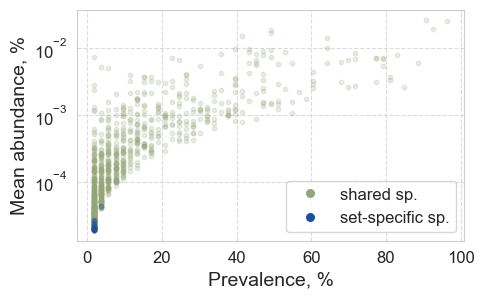

In [53]:
# assign status to mgi1_det, based on the presence of species in unique1
mgi1_det['status'] = np.where(mgi1_det.index.isin(unique1), 'unique', 'shared')
# assign status to mgi2_det, based on the presence of species in unique2
mgi2_det['status'] = np.where(mgi2_det.index.isin(unique2), 'unique', 'shared')

# Map colors to the 'status' column
color_map = {'unique': 'red', 'shared': 'blue'}
colors = mgi1_det['status'].map(color_map)

# Create the scatter plot
sh = mgi1_det[mgi1_det['status'] == 'shared']
un = mgi1_det[mgi1_det['status'] == 'unique']

plt.figure(figsize=(5,3))
sns.set_style("whitegrid")

plt.scatter(sh['prev_perc'], sh['mean_abud'], alpha=0.2, c=shared_cl, s=10)
plt.scatter(un['prev_perc'], un['mean_abud'], alpha=0.3, c=main_cl, s=10)
plt.xlabel('Prevalence, %', fontsize=14)
plt.ylabel('Mean abundance, %', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# log scale
plt.yscale('log')
# Create custom legend handles
from matplotlib.lines import Line2D
legend_elements = [
	Line2D([0], [0], marker='o', color='w', label='shared sp.', markerfacecolor=shared_cl, markersize=5),
	Line2D([0], [0], marker='o', color='w', label='set-specific sp.', markerfacecolor=main_cl, markersize=5)
]

# Add the custom legend
plt.legend(handles=legend_elements, loc='lower right', fontsize=12, markerscale=1.5)
plt.grid(linestyle='--', alpha=0.7)

plt.savefig("results/Figure_2/Fig2b.png", dpi=300, bbox_inches='tight')
plt.savefig("results/Figure_2/Fig2b.svg", bbox_inches='tight')

plt.show()

In [35]:
# Calculate the number of species for MGI-1 and MGI-2 using vectorized operations
mgi1_vals = (mgi1_df > 0).sum(axis=0)
mgi2_vals = (mgi2_df > 0).sum(axis=0)

sp_numb = pd.DataFrame({'MGI-1': mgi1_vals, 'MGI-2': mgi2_vals})
print("MGI-1 mean species per sample: ", sp_numb['MGI-1'].mean().round(1))
print("MGI-2 mean species per sample: ", sp_numb['MGI-2'].mean().round(1))
sp_numb.head(2)


MGI-1 mean species per sample:  116.6
MGI-2 mean species per sample:  115.8


,MGI-1,MGI-2
V09EVV,122,113
V0SVA4,116,116


## Higher level taxa

In [36]:
# Genus
mgi1_gen = pd.read_csv("Data/genus_BGI_dup1_merged_output_all_comma.txt", sep="\t", index_col=0)
mgi1_gen.columns = mgi1_gen.columns.str.replace('bgi_', '')
mgi2_gen = pd.read_csv("Data/genus_BGI_dup2_merged_output_all_comma.txt", sep="\t", index_col=0)
mgi2_gen.columns = mgi2_gen.columns.str.replace('bgi_dup2_', '')
# Families
mgi1_fam = pd.read_csv("Data/Family_BGI_dup1_merged_output_all_comma.txt", sep="\t", index_col=0)
mgi1_fam.columns = mgi1_fam.columns.str.replace('bgi_', '')
mgi2_fam = pd.read_csv("Data/Family_BGI_dup2_merged_output_all_comma.txt", sep="\t", index_col=0)
mgi2_fam.columns = mgi2_fam.columns.str.replace('bgi_dup2_', '')

mgi1_gen = clean_microbiome_df(mgi1_gen, shared_samples)
mgi2_gen = clean_microbiome_df(mgi2_gen, shared_samples)
mgi1_fam = clean_microbiome_df(mgi1_fam, shared_samples)
mgi2_fam = clean_microbiome_df(mgi2_fam, shared_samples)

gen = pd.DataFrame(columns=['MGI-1', 'MGI-2'])
gen1 = mgi1_df.index.str.split(" ").str.get(0).drop_duplicates()
gen2 = mgi2_df.index.str.split(" ").str.get(0).drop_duplicates()

print("All detected genera: ", len(set(gen1) | set(gen2)))
print("Genera present in both MGI-1 & MGI-2 set: ", len(set(gen1) & set(gen2)))
print("Genera present only in MGI-1 set: ", len(set(gen1) - set(gen2)))
print("Genera present only in MGI-2 set: ", len(set(gen2) - set(gen1)))

All detected genera:  380
Genera present in both MGI-1 & MGI-2 set:  368
Genera present only in MGI-1 set:  6
Genera present only in MGI-2 set:  6


In [37]:
# Genus number
mgi1_gen_vals = (mgi1_gen > 0).sum(axis=0)
mgi2_gen_vals = (mgi2_gen > 0).sum(axis=0)
gen_numb = pd.DataFrame({'MGI-1': mgi1_gen_vals, 'MGI-2': mgi2_gen_vals})
gen_numb.head(2)

,MGI-1,MGI-2
V09EVV,67,66
V0SVA4,66,66


In [38]:
# Family number
mgi1_fam_vals = (mgi1_fam > 0).sum(axis=0)
mgi2_fam_vals = (mgi2_fam > 0).sum(axis=0)

fam_numb = pd.DataFrame({'MGI-1': mgi1_fam_vals, 'MGI-2': mgi2_fam_vals})
fam_numb.head(2)

,MGI-1,MGI-2
V09EVV,87,88
V0SVA4,78,79


## Analysis & Plots

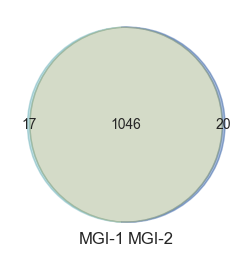

In [39]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Create a Venn diagram
plt.figure(figsize=(3, 3))
venn = venn2(subsets=(set(mgi1_df.index), set(mgi2_df.index)),
             set_labels=('MGI-1', 'MGI-2'))
venn.get_patch_by_id('10').set_color(bgi_main)
venn.get_patch_by_id('01').set_color(main_cl)
venn.get_patch_by_id('11').set_color(shared_cl)

plt.savefig("results/Figure_2/Fig2vienn.png", dpi=300, bbox_inches='tight')
plt.savefig("results/Figure_2/Fig2vienn.svg", bbox_inches='tight')

plt.show()

### Species

In [40]:
# Calculate deltas (differences between paired samples)
sp_numb['delta'] = sp_numb['MGI-1'] - sp_numb['MGI-2']

# Test normality
from scipy.stats import shapiro
shapiro(sp_numb['delta'])

from scipy.stats import wilcoxon
stat, p = wilcoxon(sp_numb['MGI-1'], sp_numb['MGI-2'])
#print("Wilcoxon test statistic:", stat)
if p<0.05:
    print("Nope, it's significantly not normal, p-value:", p)
    # OR Wilcoxon test
    from scipy.stats import wilcoxon
    stat, p_val = wilcoxon(sp_numb['MGI-1'], sp_numb['MGI-2'])
    print("Paired wilcoxon p-value:", p_val)
else:
    print("It is normal, p-value:", p)
    # Paired t-test
    from scipy.stats import ttest_rel
    t_stat, p_val = ttest_rel(sp_numb['MGI-1'], sp_numb['MGI-2'])
    print("Paired t-test p-value:", p_val)

#Quantify Effect Size
print("absolute difference between two means ", (sp_numb['MGI-1'].mean() - sp_numb['MGI-2'].mean()).round(2))
print("Cohen's d ≈ ", cohend(sp_numb['MGI-1'],sp_numb['MGI-2']).round(2))

Nope, it's significantly not normal, p-value: 0.03235230905592599
Paired wilcoxon p-value: 0.03235230905592599
absolute difference between two means  0.85
Cohen's d ≈  0.04


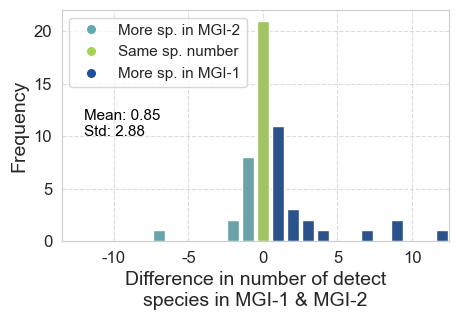

In [41]:
# plot the diferences
cnts = sp_numb['delta'].value_counts().to_frame()
cnts = cnts.reindex(range(-13, 13), fill_value=0)
cnts = cnts.reset_index()  
cnts = cnts.sort_values(by='index')

colors = []
for val in range(-13, 14):
    if val < 0:
        colors.append(bgi_main)  
    elif val == 0:
        colors.append("#a5d455")     
    else:
        colors.append(main_cl)  
        
# 3. Plot the boxplot
plt.figure(figsize=(5, 3))
ax = sns.barplot(x='index', y='delta', data=cnts, palette=colors)

# Define which ticks to show
ticks_to_show = [-10, -5, 0, 5, 10]
tick_positions = [cnts[cnts['index'] == val].index[0] for val in ticks_to_show if val in cnts['index'].values]
ax.set_xticks(tick_positions)
ax.set_xticklabels([str(t) for t in ticks_to_show])

plt.xlabel('Difference in number of detect\nspecies in MGI-1 & MGI-2', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.xlim(-13, 13)
plt.text(1, 10, f'Mean: {np.mean(sp_numb["delta"]):.2f}\nStd: {np.std(sp_numb["delta"]):.2f}', fontsize=11, color='black')

# Create custom legend handles
from matplotlib.lines import Line2D
legend_elements = [
	Line2D([0], [0], marker='o', color='w', label='More sp. in MGI-2', markerfacecolor=bgi_main, markersize=5),
    Line2D([0], [0], marker='o', color='w', label='Same sp. number', markerfacecolor="#a5d455", markersize=5),
	Line2D([0], [0], marker='o', color='w', label='More sp. in MGI-1', markerfacecolor=main_cl, markersize=5)
]

# Add the custom legend
plt.legend(handles=legend_elements, loc='upper left', fontsize=11, markerscale=1.5)
plt.grid(linestyle='--', alpha=0.7)

plt.savefig("results/Figure_2/Fig2c.png", dpi=300, bbox_inches='tight')
plt.savefig("results/Figure_2/Fig2c.svg", bbox_inches='tight')

plt.show()


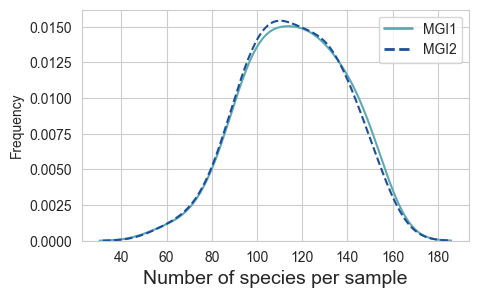

In [42]:
from matplotlib.lines import Line2D

plt.figure(figsize=(5,3))
sns.set_style('whitegrid')
sns.kdeplot(sp_numb, x="MGI-1", color=bgi_main)
sns.kdeplot(sp_numb, x="MGI-2", color=main_cl, linestyle='dashed')

plt.xlabel("Number of species per sample", fontsize=14)
plt.ylabel("Frequency")
# Custom legend handles
legend_elements = [
    Line2D([0], [0], color=bgi_main, lw=2, linestyle='-', label='MGI1'),
    Line2D([0], [0], color=main_cl, lw=2, linestyle='dashed', label='MGI2')
]

# Add the custom legend
plt.legend(handles=legend_elements)

plt.savefig("results/Figure_2/Suppl-1.png", dpi=300, bbox_inches='tight')
#plt.savefig("results/Figure_2/Suppl-1.svg", bbox_inches='tight')

plt.show()

### Genus

Paired t-test statistic: 1.1969348608944808
Paired t-test p-value: 0.23676036599490208


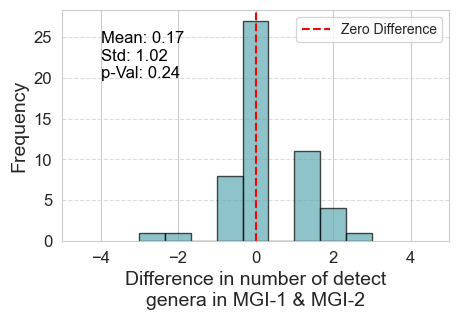

In [43]:
# calculate paired t-test
from scipy import stats
t_stat, p_val = stats.ttest_rel(gen_numb['MGI-1'], gen_numb['MGI-2'])
print("Paired t-test statistic:", t_stat)
print("Paired t-test p-value:", p_val)

# Calculate deltas (differences between paired samples)
gen_numb['delta'] = gen_numb['MGI-1'] - gen_numb['MGI-2']

# Plot the distribution of deltas
plt.figure(figsize=(5,3))
plt.hist(gen_numb['delta'], bins=9, color=bgi_main, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label='Zero Difference')
plt.xlabel('Difference in number of detect\ngenera in MGI-1 & MGI-2', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-5, 5)
plt.text(-4, 20, f'Mean: {np.mean(gen_numb["delta"]):.2f}\nStd: {np.std(gen_numb["delta"]):.2f}\np-Val: {p_val:.2f}', fontsize=12, color='black')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig("results/Figure_2/Suppl-2.png", dpi=300, bbox_inches='tight')
#plt.savefig("results/Figure_2/Suppl-2.svg", bbox_inches='tight')

plt.show()


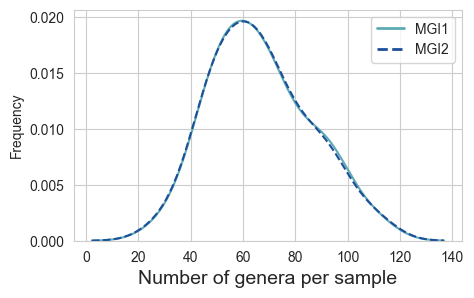

In [44]:
from matplotlib.lines import Line2D

plt.figure(figsize=(5,3))
sns.set_style('whitegrid')
sns.kdeplot(gen_numb, x="MGI-1", color=bgi_main)
sns.kdeplot(gen_numb, x="MGI-2", color=main_cl, linestyle='dashed')
#plt.yscale("log")
#plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.xlabel("Number of genera per sample", fontsize=14)
plt.ylabel("Frequency")
# Custom legend handles
legend_elements = [
    Line2D([0], [0], color=bgi_main, lw=2, linestyle='-', label='MGI1'),
    Line2D([0], [0], color=main_cl, lw=2, linestyle='dashed', label='MGI2')
]

# Add the custom legend
plt.legend(handles=legend_elements)

plt.savefig("results/Figure_2/Suppl-3.png", dpi=300, bbox_inches='tight')
#plt.savefig("results/Figure_2/Suppl-3.svg", bbox_inches='tight')

plt.show()

## Families

Paired t-test statistic: 0.5979108259504828
Paired t-test p-value: 0.5524946939626832


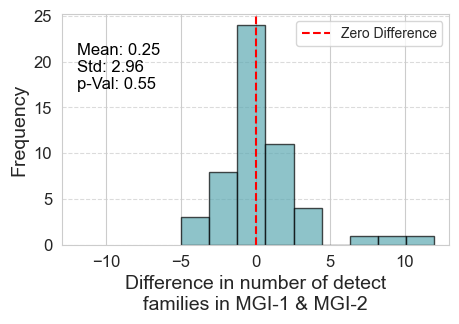

In [45]:
# calculate paired t-test
from scipy import stats
t_stat, p_val = stats.ttest_rel(fam_numb['MGI-1'], fam_numb['MGI-2'])
print("Paired t-test statistic:", t_stat)
print("Paired t-test p-value:", p_val)

# Calculate deltas (differences between paired samples)
fam_numb['delta'] = fam_numb['MGI-1'] - fam_numb['MGI-2']

# Plot the distribution of deltas
plt.figure(figsize=(5,3))
plt.hist(fam_numb['delta'], bins=9, color=bgi_main, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label='Zero Difference')
plt.xlabel('Difference in number of detect\nfamilies in MGI-1 & MGI-2', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-13, 13)
plt.text(-12, 17, f'Mean: {np.mean(fam_numb["delta"]):.2f}\nStd: {np.std(fam_numb["delta"]):.2f}\np-Val: {p_val:.2f}', fontsize=12, color='black')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig("results/Figure_2/Suppl-4.png", dpi=300, bbox_inches='tight')
#plt.savefig("results/Figure_2/Suppl-4.svg", bbox_inches='tight')

plt.show()


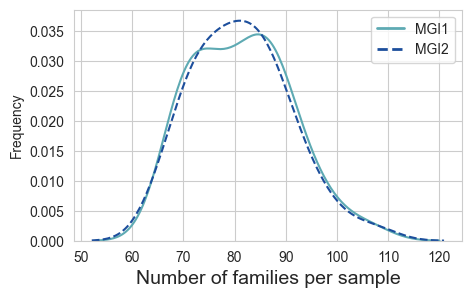

In [46]:
from matplotlib.lines import Line2D

plt.figure(figsize=(5,3))
sns.set_style('whitegrid')
sns.kdeplot(fam_numb, x="MGI-1", color=bgi_main)
sns.kdeplot(fam_numb, x="MGI-2", color=main_cl, linestyle='dashed')
#plt.yscale("log")
#plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.xlabel("Number of families per sample", fontsize=14)
plt.ylabel("Frequency")
# Custom legend handles
legend_elements = [
    Line2D([0], [0], color=bgi_main, lw=2, linestyle='-', label='MGI1'),
    Line2D([0], [0], color=main_cl, lw=2, linestyle='dashed', label='MGI2')
]

# Add the custom legend
plt.legend(handles=legend_elements)

plt.savefig("results/Figure_2/Suppl-5.png", dpi=300, bbox_inches='tight')
#plt.savefig("results/Figure_2/Suppl-5.svg", bbox_inches='tight')

plt.show()

## Share percentage

In [51]:
shared_sp = pd.read_excel('input/shared_species_MGI-MGI.xlsx')
print('Numer of smpls in file:', len(shared_sp))
shared_sp.head(2)

Numer of smpls in file: 53


,index,mgi1,shared,mgi2,sample,bottom
0,16,0.0,100.0,0.0,VM6LXC,100.0
1,11,0.0,100.0,0.0,VD5OV9,100.0


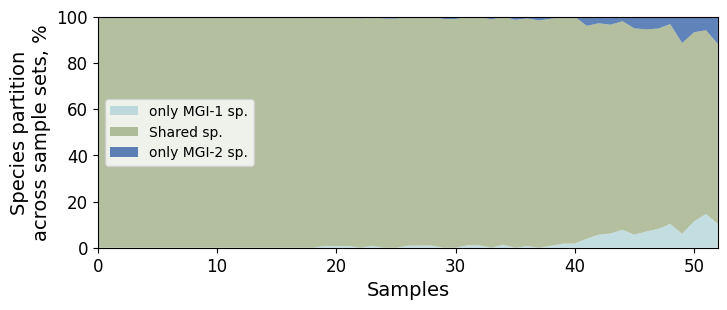

In [54]:
plt.figure(figsize=(8,3))
sns.set_style('white')
sns.reset_defaults()
plt.stackplot(shared_sp.index, shared_sp.mgi1, shared_sp.shared, shared_sp.mgi2, labels=['only MGI-1 sp.', 'Shared sp.','only MGI-2 sp.'], colors=[bgi_lght, shared_cl, main_cl], alpha = 0.7)
plt.legend(loc='center left') #bbox_to_anchor=(1.1, 1.0))
plt.xlabel("Samples", fontsize=14)
plt.ylabel("Species partition\nacross sample sets, %", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0,52])
plt.ylim([0,100])

plt.savefig("results/Figure_2/Fig2d.png", dpi=300, bbox_inches='tight')
plt.savefig("results/Figure_2/Fig2d.svg", bbox_inches='tight')

plt.show()

96.44492665486722
5.956643770375364


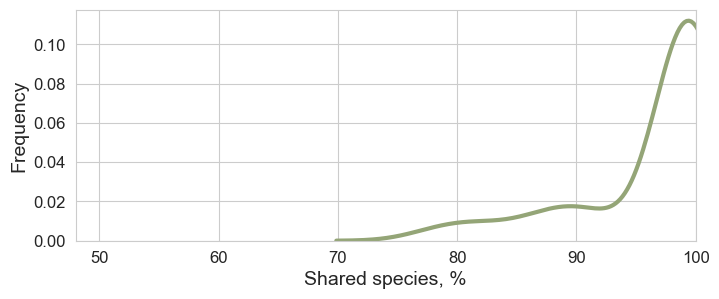

In [ ]:
plt.figure(figsize=(8,3))
sns.set_style("whitegrid")

sns.kdeplot(list(shared_sp.sort_values(by='shared', ascending=True)['shared']), color=shared_cl, linewidth=3) 
plt.grid()
#plt.title("Distribution of the fraction of shared species")
plt.ylabel("Frequency", fontsize=14)
plt.xlabel("Shared species, %", fontsize=14)
plt.xlim(48, 100)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().invert_xaxis()
plt.grid()

print(shared_sp['shared'].mean())
print(shared_sp['shared'].std())

plt.savefig("results/Figure_2/Fig2e.png", dpi=300, bbox_inches='tight')
plt.savefig("results/Figure_2/Fig2e.svg", bbox_inches='tight')

plt.show()

## Prevalence & rel. abundance

In [ ]:
# calculate non zero columns per each raw mgi1_df
mgi1_prev = mgi1_df.copy()
mgi1_prev['prev_numb'] = (mgi1_prev  != 0).sum(axis=1)
mgi1_prev['prev_perc'] = mgi1_prev['prev_numb'] / (len(mgi1_prev.columns)-1) * 100
# mean per sample
mgi1_ab = mgi1_df.copy()
mgi1_ab['mean_abud'] = mgi1_ab.mean(axis=1)
# Ensure both DataFrames have the same index before merging
mgi1_det = pd.merge(mgi1_prev[['prev_numb', 'prev_perc']], mgi1_ab[['mean_abud']], left_index=True, right_index=True)

mgi2_prev = mgi2_df.copy()
# calculate non zero columns per each raw mgi2_df
mgi2_prev['prev_numb'] = (mgi2_prev  != 0).sum(axis=1)
mgi2_prev['prev_perc'] = mgi2_prev['prev_numb'] / (len(mgi2_prev.columns)-1) * 100
# mean per sample
mgi2_ab = mgi2_df.copy()
mgi2_ab['mean_abud'] = mgi2_ab.mean(axis=1)
# Ensure both DataFrames have the same index before merging     
mgi2_det = pd.merge(mgi2_prev[['prev_numb', 'prev_perc']], mgi2_ab[['mean_abud']], left_index=True, right_index=True)

mrg = pd.merge(mgi1_det, mgi2_det, left_index=True, right_index=True, suffixes=('_mgi1', '_mgi2'))
mrg.head(2)


,prev_numb_mgi1,prev_perc_mgi1,mean_abud_mgi1,prev_numb_mgi2,prev_perc_mgi2,mean_abud_mgi2
name,,,,,,
Phocaeicola plebeius_A,26,49.056604,0.016353,26,49.056604,0.016259
Phocaeicola sp000432735,14,26.415094,0.004032,14,26.415094,0.003939


R^2: 0.9999108715563118


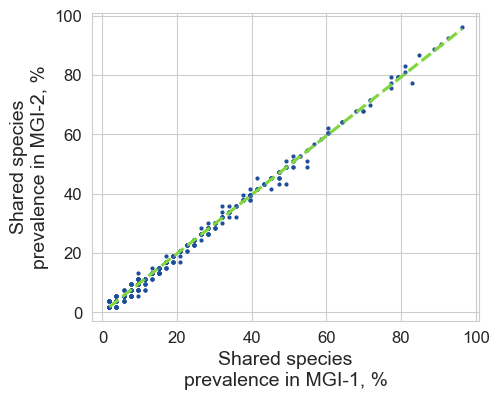

In [ ]:
# Scatter plot and regression line
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
plt.figure(figsize=(5, 4))

plt.scatter(mrg['prev_perc_mgi1'], mrg['prev_perc_mgi2'], s=4, color=main_cl)
plt.grid()

# Fitting the linear regression model to calculate residuals
X = mrg['prev_perc_mgi1'].values.reshape(-1, 1)
y = mrg['prev_perc_mgi2'].values
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(X, y_pred)
print("R^2:", r2)
# Calculate residuals
residuals = y - y_pred

# Add regression line
sns.regplot(x=mrg['prev_perc_mgi1'], y=mrg['prev_perc_mgi2'], scatter=False, line_kws={"color": "#81d640", "linestyle": "--"})
plt.ylabel("Shared species\nprevalence in MGI-2, %", fontsize=14)
plt.xlabel("Shared species\nprevalence in MGI-1, %", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.text(0.1, 0.9, f'$R^2$ = {r2:.3f}', fontsize=12, color='black', transform=plt.gca().transAxes)
plt.grid()
plt.savefig("results/Figure_2/Fig2f.png", dpi=300, bbox_inches='tight')
plt.savefig("results/Figure_2/Fig2f.svg", bbox_inches='tight')

plt.show()

R^2: 0.9999879434306659


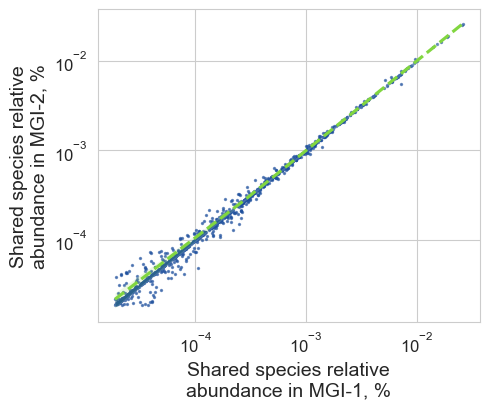

In [ ]:
plt.figure(figsize=(5,4))

# Smooth scatter (KDE) and scatter plot combined
plt.scatter(mrg['mean_abud_mgi1'], mrg['mean_abud_mgi2'], s=2, color=main_cl, alpha=0.6)
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Species relative abundance in MGI1, %", fontsize=14)
plt.ylabel("Species relative\nabundance in MGI2, %", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#residuals_clipped = np.clip(residuals, a_min=1e-5, a_max=None)
plt.tight_layout()

# Fitting the linear regression model to calculate residuals
X = mrg['mean_abud_mgi1'].values.reshape(-1, 1)
y = mrg['mean_abud_mgi2'].values
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(X, y_pred)
print("R^2:", r2)
# Calculate residuals
residuals = y - y_pred

# Add regression line
sns.regplot(x=mrg['mean_abud_mgi1'], y=mrg['mean_abud_mgi2'], scatter=False, line_kws={"color": "#81d640", "linestyle": "--"})
plt.grid()
plt.xlabel("Shared species relative\nabundance in MGI-1, %", fontsize=14)
plt.ylabel("Shared species relative\nabundance in MGI-2, %", fontsize=14)

plt.savefig("results/Figure_2/Fig2g.png", dpi=300, bbox_inches='tight')
plt.savefig("results/Figure_2/Fig2g.svg", bbox_inches='tight')

plt.show()

# Shannon Idx

In [ ]:
# calculate shannon
from skbio.diversity.alpha import shannon, simpson

alpha1 = mgi1_df.T.apply(shannon, axis=1)
alpha1 = pd.DataFrame(alpha1)
alpha1.columns = ['shannon']
alpha1['Sequencing'] = 'MGI1'

alpha2 = mgi2_df.T.apply(shannon, axis=1)
alpha2 = pd.DataFrame(alpha2)
alpha2.columns = ['shannon']
alpha2['Sequencing'] = 'MGI2'

alpha = pd.concat([alpha1, alpha2], axis=0)
alpha = alpha.reset_index()
print(len(alpha))
alpha.head(2)

106


/Users/katerynapantiukh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


,index,shannon,Sequencing
0,V09EVV,3.824831,MGI1
1,V5IRLB,4.169111,MGI1


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MGI1 v.s. MGI2: t-test paired samples with Bonferroni correction, P_val=9.237e-01 stat=9.627e-02


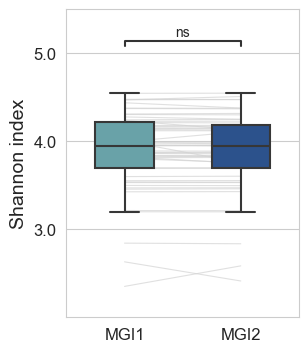

In [ ]:
from statannot import add_stat_annotation
pairs = [('MGI1', 'MGI2')]  # Correct group names

plt.figure(figsize=(3, 4))
ax = plt.gca()

# 1. Draw grey lines connecting the pairs first (so they're underneath the boxes)
if "index" in alpha.columns:
    for sample_id, group in alpha.groupby("index"):
        if group.shape[0] == 2:
            x_vals = [0, 1] if group.iloc[0]["Sequencing"] == "MGI1" else [1, 0]
            y_vals = group.sort_values("Sequencing")["shannon"].values
            ax.plot(x_vals, y_vals, color='lightgrey', linewidth=0.8, alpha=0.7, zorder=0)  # zorder=1 ensures background

# 2. Draw the boxplot after (so it's on top)
sns.boxplot(data=alpha, x="Sequencing", y="shannon",zorder=1,
            fliersize=0, palette=[bgi_main, main_cl], width=0.5, ax=ax)

plt.ylabel("Shannon index", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks([3, 4, 5], labels=[3.0, 4.0, 5.0], fontsize=12)

# Add statistical annotations
add_stat_annotation(ax, data=alpha, x="Sequencing", y="shannon",
                    box_pairs=pairs,
                    test='t-test_paired',
                    text_format='star',  
                    loc='outside', verbose=2)

plt.ylim([2, 5.5])
plt.xlabel("")
plt.savefig("results/Figure_2/Fig2h.png", dpi=300, bbox_inches='tight')
plt.savefig("results/Figure_2/Fig2h.svg", bbox_inches='tight')
plt.show()


## Calculate shared fraction if needed

In [50]:
# shared_fraction
mgi1_only = []
mgi2_only = []
shared = []
x_names = []
bottom_list = []

for a in shared_samples:
    try:
        sample_mgi1_only = 0
        sample_mgi2_only = 0
        sample_shared = 0

        in_mgi1 = list(mgi1_df.loc[mgi1_df[a] > 0].index)
        in_mgi2 = list(mgi2_df.loc[mgi2_df[a] > 0].index)
        all_found = list(set(in_mgi1 + in_mgi2))
        for b in all_found:
            if b in in_mgi1 and b not in in_mgi2:
                sample_mgi1_only += 1
            elif b not in in_mgi1 and b in in_mgi2:
                sample_mgi2_only += 1
            elif b in in_mgi1 and b in in_mgi2:
                sample_shared += 1
        mgi1_only.append(100*sample_mgi1_only/len(all_found))
        mgi2_only.append(100*sample_mgi2_only/len(all_found))
        shared.append(100*sample_shared/len(all_found))
        bottom_list.append(100*sample_mgi1_only/len(all_found) + 100*sample_shared/len(all_found))
        x_names.append(a)
    except:
        print(a)

stacked_df = pd.DataFrame(columns = ['mgi1','shared','mgi2','sample','bottom'])
stacked_df['mgi1'] = mgi1_only
stacked_df['mgi2'] = mgi2_only
stacked_df['shared'] = shared
stacked_df['sample'] = x_names
stacked_df['bottom'] = bottom_list
stacked_df = stacked_df.sort_values(by="shared", ascending=False).reset_index()

stacked_df.to_excel('input/shared_species_MGI-MGI.xlsx', index=False)
